---
format:
    html:
        embed-resources: true
---

## Data

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers, regularizers
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('clean_data/final_merged_data.csv')

print(df.columns)
print(len(df))
print(len(df[df['bestseller'] == 1]))
print(len(df['restaurant'].unique()))

Index(['restaurant', 'item', 'ms_item', 'matched_2021', 'new_item_2022',
       'food_category', 'item_description', 'calories', 'total_fat',
       'saturated_fat', 'trans_fat', 'cholesterol', 'sodium', 'carbohydrates',
       'dietary_fiber', 'sugar', 'protein', 'bestseller', 'price'],
      dtype='object')
978
275
18


Clean and Prepare Data

In [3]:
# Drop the columns that are not needed for the model
df = df.drop(columns=['restaurant', 'item', 'ms_item', 'item_description'])

numeric_cols = [
    'matched_2021', 'new_item_2022', 'calories', 'total_fat', 'saturated_fat', 'trans_fat',
    'cholesterol', 'sodium', 'carbohydrates', 'dietary_fiber',
    'sugar', 'protein', 'price' 
]

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['food_category'], drop_first=True)

# Check the number of missing values
print("CHECK NUMBER OF NA: \n", df.isna().sum())

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill in missing numeric values
df.fillna(df.median(numeric_only=True), inplace=True)

df.isnull().sum()




CHECK NUMBER OF NA: 
 matched_2021                             0
new_item_2022                            0
calories                                 0
total_fat                                0
saturated_fat                            0
trans_fat                                0
cholesterol                              4
sodium                                   0
carbohydrates                            1
dietary_fiber                           20
sugar                                    8
protein                                  1
bestseller                               0
price                                   22
food_category_Baked Goods                0
food_category_Beverages                  0
food_category_Burgers                    0
food_category_Desserts                   0
food_category_Entrees                    0
food_category_Fried Potatoes             0
food_category_Pizza                      0
food_category_Salads                     0
food_category_Sandwiches        

matched_2021                            0
new_item_2022                           0
calories                                0
total_fat                               0
saturated_fat                           0
trans_fat                               0
cholesterol                             0
sodium                                  0
carbohydrates                           0
dietary_fiber                           0
sugar                                   0
protein                                 0
bestseller                              0
price                                   0
food_category_Baked Goods               0
food_category_Beverages                 0
food_category_Burgers                   0
food_category_Desserts                  0
food_category_Entrees                   0
food_category_Fried Potatoes            0
food_category_Pizza                     0
food_category_Salads                    0
food_category_Sandwiches                0
food_category_Soup                

In [4]:
df.shape

(978, 25)

## Modeling with logistic regression and K-fold


 Fold 1
              precision    recall  f1-score   support

           0       0.87      0.60      0.71       141
           1       0.43      0.76      0.55        55

    accuracy                           0.65       196
   macro avg       0.65      0.68      0.63       196
weighted avg       0.74      0.65      0.67       196

F1 Score: 0.5490, Accuracy: 0.6480


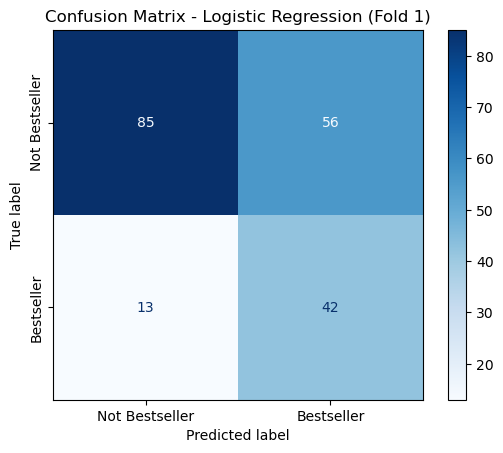


 Fold 2
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       141
           1       0.49      0.80      0.61        55

    accuracy                           0.71       196
   macro avg       0.69      0.74      0.69       196
weighted avg       0.78      0.71      0.72       196

F1 Score: 0.6069, Accuracy: 0.7092


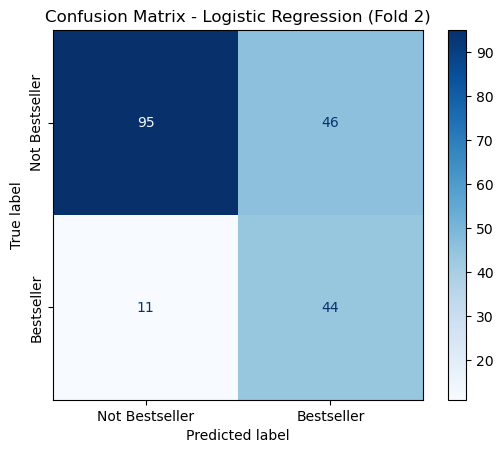


 Fold 3
              precision    recall  f1-score   support

           0       0.86      0.66      0.75       141
           1       0.45      0.73      0.56        55

    accuracy                           0.68       196
   macro avg       0.66      0.69      0.65       196
weighted avg       0.75      0.68      0.69       196

F1 Score: 0.5594, Accuracy: 0.6786


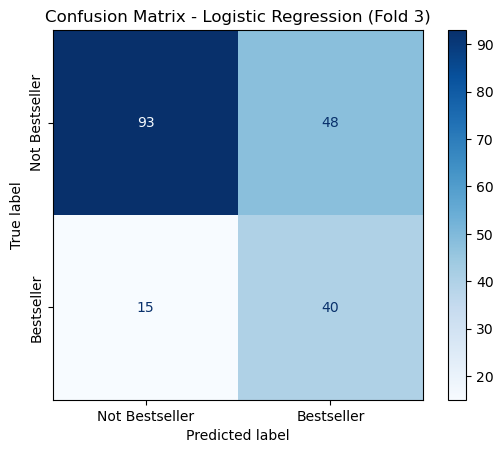


 Fold 4
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       140
           1       0.37      0.58      0.45        55

    accuracy                           0.60       195
   macro avg       0.58      0.59      0.57       195
weighted avg       0.67      0.60      0.62       195

F1 Score: 0.4507, Accuracy: 0.6000


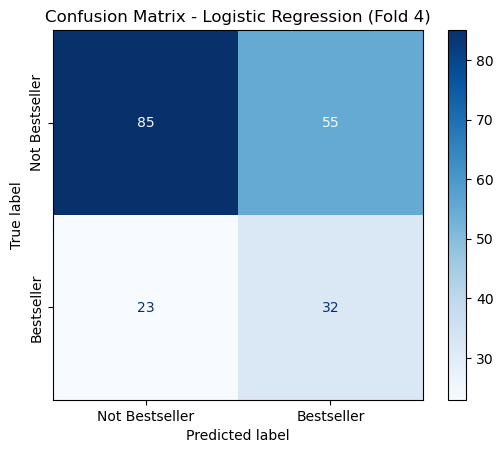


 Fold 5
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       140
           1       0.43      0.60      0.50        55

    accuracy                           0.66       195
   macro avg       0.62      0.64      0.62       195
weighted avg       0.70      0.66      0.68       195

F1 Score: 0.5000, Accuracy: 0.6615


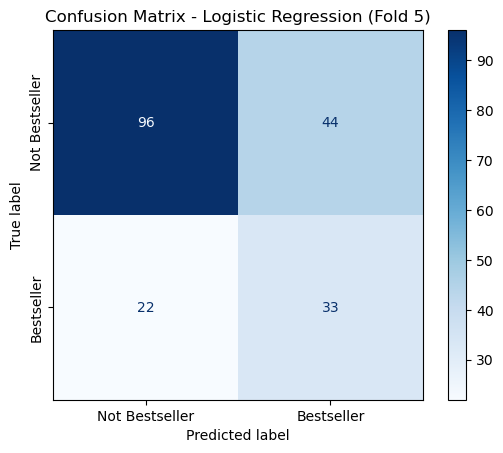


 Cross-Validation Results
Average F1 Score: 0.5332
Average Accuracy: 0.6595


In [14]:
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

# Define features and target
X = df.drop(columns=['bestseller'])
y = df['bestseller'].astype(int)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
accuracy_scores = []

# K-Fold training loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)

    print(f"\n Fold {fold+1}")
    print(classification_report(y_val, y_pred))
    print(f"F1 Score: {f1:.4f}, Accuracy: {acc:.4f}")

    # Plot confusion matrix with custom labels
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Bestseller", "Bestseller"])
    disp.plot(cmap='Blues')
    ax = plt.gca()
    ax.set_yticklabels(["Not Bestseller", "Bestseller"], va='center', rotation=90)
    ax.set_xticklabels(["Not Bestseller", "Bestseller"], ha='center')
    plt.title(f'Confusion Matrix - Logistic Regression (Fold {fold+1})')
    plt.show()

    f1_scores.append(f1)
    accuracy_scores.append(acc)

print("\n Cross-Validation Results")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")



## SVM Model 

In [ ]:
from sklearn.svm import SVC
# Scale your features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
accuracy_scores = []

# Loop through folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Support Vector Classifier with balanced class weights
    model = SVC(kernel='rbf', class_weight='balanced', probability=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)

    print(f"\n Fold {fold + 1}")
    print(classification_report(y_val, y_pred))
    print(f"F1 Score: {f1:.4f}, Accuracy: {acc:.4f}")

    f1_scores.append(f1)
    accuracy_scores.append(acc)

# Final performance
print("\n SVM Cross-Validation Results")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")


🔁 Fold 1
              precision    recall  f1-score   support

           0       0.85      0.65      0.73       141
           1       0.44      0.71      0.54        55

    accuracy                           0.66       196
   macro avg       0.64      0.68      0.64       196
weighted avg       0.73      0.66      0.68       196

F1 Score: 0.5417, Accuracy: 0.6633

🔁 Fold 2
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       141
           1       0.56      0.82      0.67        55

    accuracy                           0.77       196
   macro avg       0.74      0.78      0.75       196
weighted avg       0.82      0.77      0.78       196

F1 Score: 0.6667, Accuracy: 0.7704

🔁 Fold 3
              precision    recall  f1-score   support

           0       0.88      0.74      0.81       141
           1       0.53      0.75      0.62        55

    accuracy                           0.74       196
   macro avg       0.71     

In [ ]:
#### Ignore 
## grid search for svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create a pipeline: scale features + run SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

# Define parameter grid
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.01, 0.1, 1],
    'svc__kernel': ['linear', 'rbf']
}

# Use StratifiedKFold for class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',  # Focus on F1 score due to class imbalance
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to your full dataset
grid_search.fit(X, y)

# Best model and params
print("\n Best Parameters:")
print(grid_search.best_params_)

print("\nBest Cross-Validated F1 Score:")
print(grid_search.best_score_)

# Optionally evaluate on best model
y_pred = grid_search.best_estimator_.predict(X)
print("\nPerformance on Entire Dataset:")
print(classification_report(y, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__

In [ ]:
### Ignore
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# Train GridSearchCV on X_train, evaluate on X_test
grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.0s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.0s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=   0.0s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=   0.0s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, sv

<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:23: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:23: SyntaxWarning: invalid escape sequence '\$'
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/3346043649.py:21: SyntaxWarning: invalid escape sequence '\$'
  df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/3346043649.py:23: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True)


Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Best Parameters:
{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}


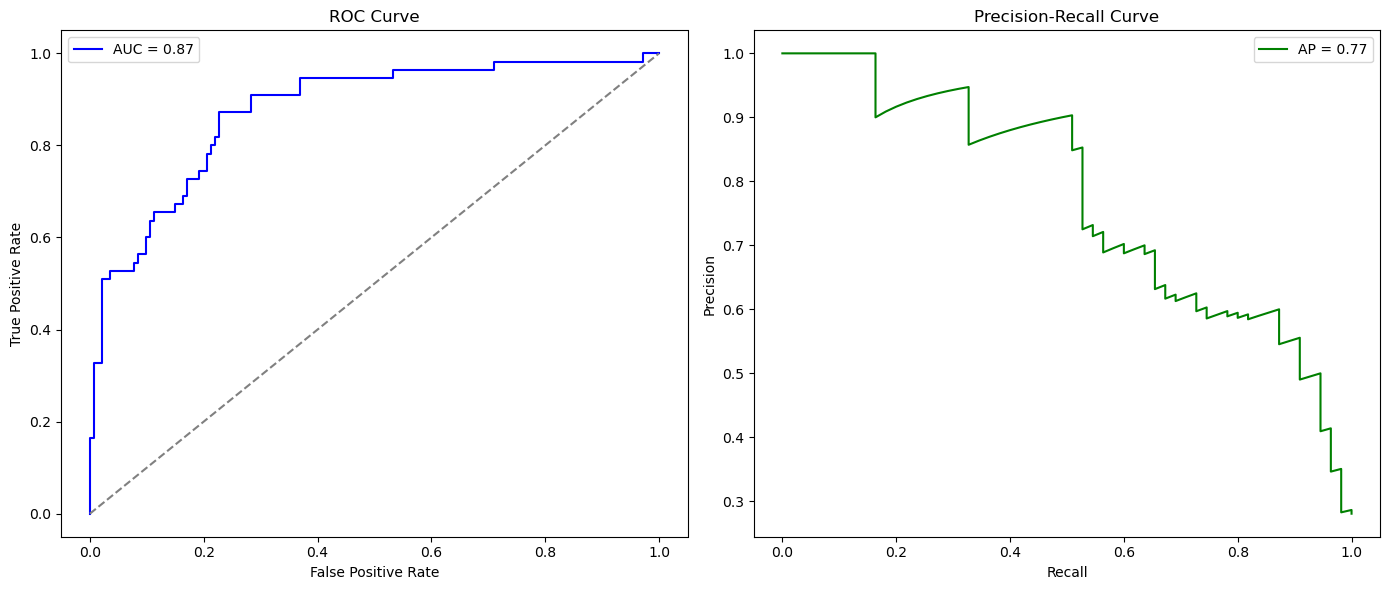


📊 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       141
           1       0.65      0.65      0.65        55

    accuracy                           0.81       196
   macro avg       0.76      0.76      0.76       196
weighted avg       0.81      0.81      0.81       196



In [ ]:
#### all the svm code combined

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    classification_report
)

# Load data
df = pd.read_csv("clean_data/final_merged_data.csv")

# Clean & convert necessary columns
df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
df['sodium'] = pd.to_numeric(df['sodium'], errors='coerce')
df['price'] = df['price'].replace('[\$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop unwanted columns
df = df.drop(columns=['item', 'ms_item', 'item_description', 'restaurant'])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['food_category'], drop_first=True)

# Fill missing values
df = df.fillna(df.median(numeric_only=True))

# Define features and target
X = df.drop(columns=['bestseller'])
y = df['bestseller'].astype(int)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Build SVM pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

# Parameter grid for tuning
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.01, 0.1, 1],
    'svc__kernel': ['linear', 'rbf']
}

# Grid search with 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model from search
best_model = grid_search.best_estimator_
print("\nBest Parameters:")
print(grid_search.best_params_)

# Predict probabilities on test set
y_scores = best_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# PR curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

# Plot ROC & PR
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ROC plot
axs[0].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0].set_title("ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()

# PR plot
axs[1].plot(recall, precision, color='green', label=f'AP = {pr_auc:.2f}')
axs[1].set_title("Precision-Recall Curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

plt.tight_layout()
plt.show()

# Final classification report
y_pred = best_model.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))



Fitting 5 folds for each of 24 candidates, totalling 120 fits


<>:19: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:19: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\$'
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/4238009645.py:19: SyntaxWarning: invalid escape sequence '\$'
  df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/4238009645.py:21: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True)



Best Parameters:
{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'rbf'}


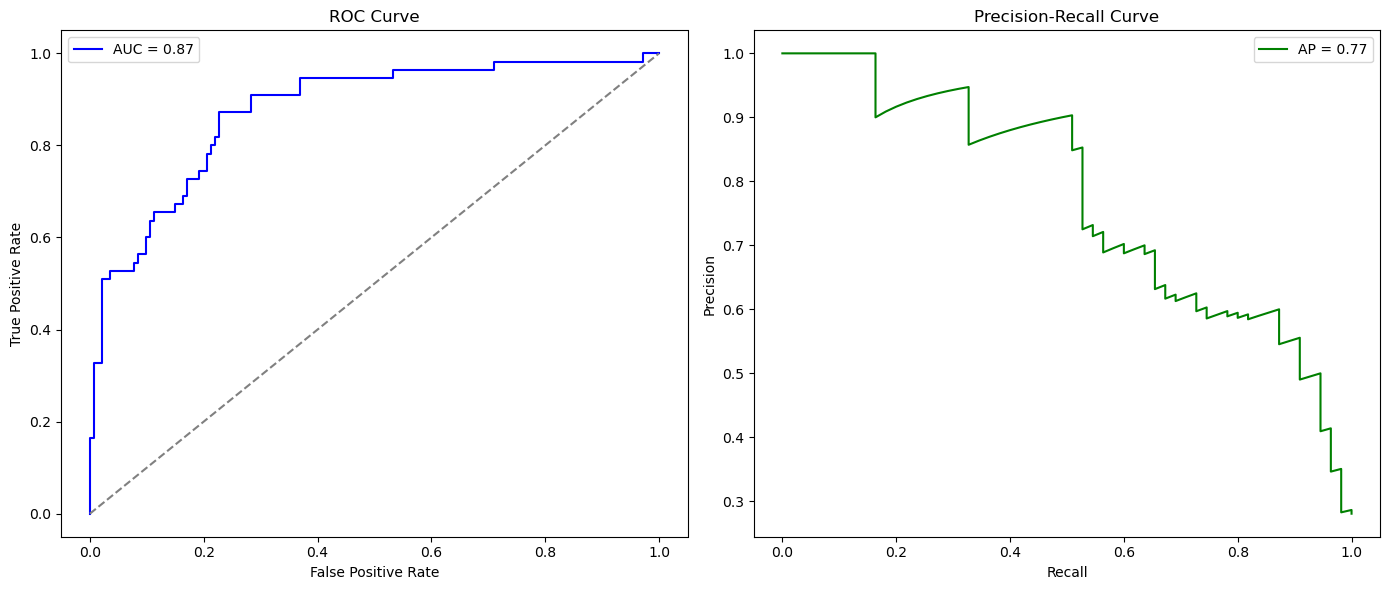


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       141
           1       0.65      0.65      0.65        55

    accuracy                           0.81       196
   macro avg       0.76      0.76      0.76       196
weighted avg       0.81      0.81      0.81       196

SVC(C=1, class_weight='balanced', gamma=1, probability=True)
🔝 Top Features (Permutation Importance):
food_category_Sandwiches    0.064286
protein                     0.042857
trans_fat                   0.041837
matched_2021                0.040816
new_item_2022               0.040816
food_category_Burgers       0.039286
sodium                      0.031122
sugar                       0.028571
food_category_Salads        0.026020
food_category_Entrees       0.021429
dtype: float64


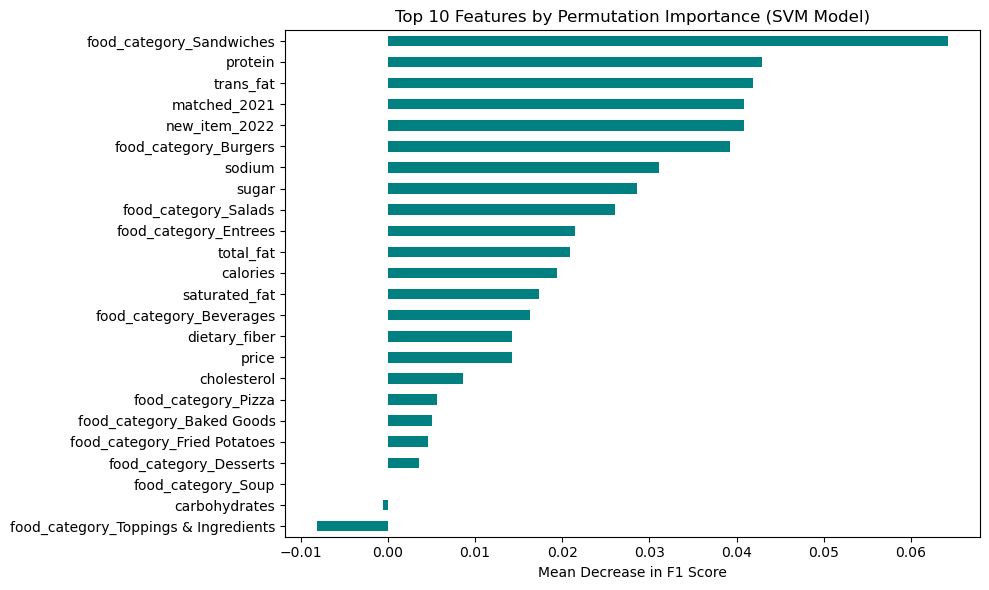

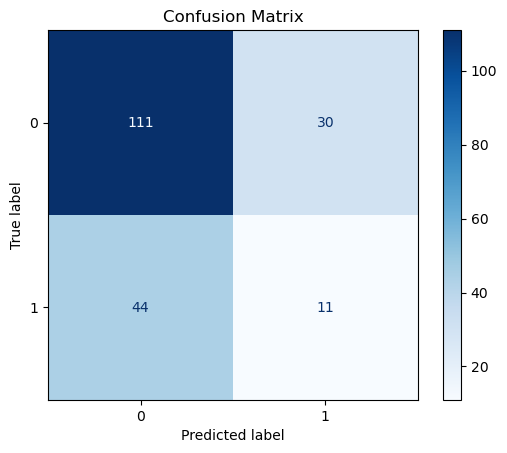

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    classification_report
)

# Load data
df = pd.read_csv("clean_data/final_merged_data.csv")

# Clean & convert necessary columns
df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
df['sodium'] = pd.to_numeric(df['sodium'], errors='coerce')
df['price'] = df['price'].replace('[\$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop unwanted columns
df = df.drop(columns=['item', 'ms_item', 'item_description', 'restaurant'])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['food_category'], drop_first=True)

# Fill missing values
df = df.fillna(df.median(numeric_only=True))

# Define features and target
X = df.drop(columns=['bestseller'])
y = df['bestseller'].astype(int)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Build SVM pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

# Parameter grid for tuning
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.01, 0.1, 1],
    'svc__kernel': ['linear', 'rbf']
}

# Grid search with 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model from search
best_model = grid_search.best_estimator_
print("\nBest Parameters:")
print(grid_search.best_params_)

# Predict probabilities on test set
y_scores = best_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# PR curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

# Plot ROC & PR
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# ROC plot
axs[0].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0].set_title("ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()

# PR plot
axs[1].plot(recall, precision, color='green', label=f'AP = {pr_auc:.2f}')
axs[1].set_title("Precision-Recall Curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

plt.tight_layout()
plt.show()

# Final classification report
y_pred = best_model.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))
print(best_model.named_steps['svc'])


## permuation importance
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Run permutation importance on the test set
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create Series of importances
importances = pd.Series(result.importances_mean, index=X.columns)

# Sort and show top features
top_features = importances.sort_values(ascending=False)
print("🔝 Top Features (Permutation Importance):")
print(top_features.head(10))

# Plot the feature importances
importances_series = pd.Series(top_features).sort_values()

plt.figure(figsize=(10, 6))
importances_series.plot(kind='barh', color='teal')
plt.xlabel("Mean Decrease in F1 Score")
plt.title("Top 10 Features by Permutation Importance (SVM Model)")
plt.tight_layout()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

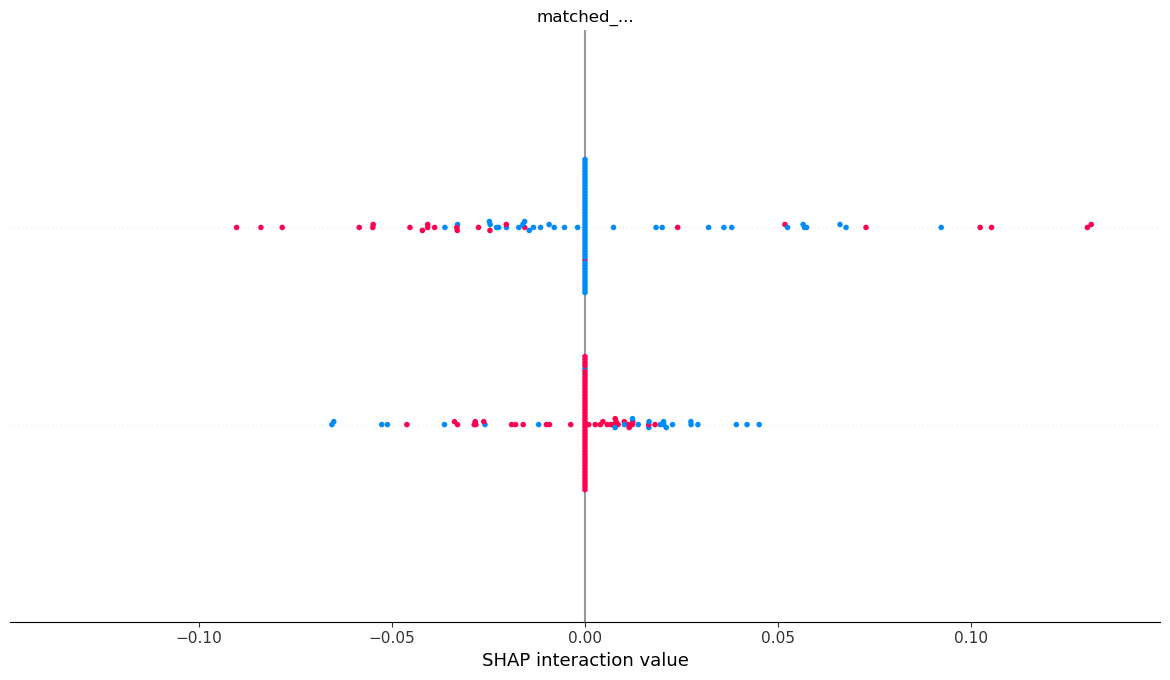

In [46]:
import shap
import numpy as np

# Use a sample of the test set (SHAP KernelExplainer is slow)
X_sample = X_test.sample(n=100, random_state=42)
X_sample_scaled = best_model.named_steps['scaler'].transform(X_sample)

# Extract the trained SVC model
svc = best_model.named_steps['svc']

# SHAP expects a function that outputs predicted probabilities
def model_predict(X_scaled):
    return svc.predict_proba(X_scaled)

# Create the SHAP explainer
explainer = shap.KernelExplainer(model_predict, X_sample_scaled)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample_scaled)

# Plot summary
shap.summary_plot(shap_values, features=X_sample, feature_names=X_sample.columns)

Feature Selection

In [ ]:
### forward selection on SVM


from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define base model
svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', class_weight='balanced', probability=True))
])

# Forward feature selection ('auto' best features)
selector = SequentialFeatureSelector(
    estimator=svm,
    n_features_to_select='auto',  
    direction='forward',
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit selector on training data
selector.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

# Retrain model on selected features only
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

svm.fit(X_train_sel, y_train)
y_pred = svm.predict(X_test_sel)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))


Selected features: ['matched_2021', 'total_fat', 'cholesterol', 'sodium', 'carbohydrates', 'sugar', 'protein', 'food_category_Entrees', 'food_category_Fried Potatoes', 'food_category_Salads', 'food_category_Sandwiches', 'food_category_Soup']

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       141
           1       0.50      0.75      0.60        55

    accuracy                           0.72       196
   macro avg       0.69      0.73      0.69       196
weighted avg       0.77      0.72      0.73       196



In [38]:
## forward selection on logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report

# 1. Split your dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Create logistic regression pipeline
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# 3. Set up forward feature selection
selector = SequentialFeatureSelector(
    estimator=logreg_pipeline,
    direction='forward',
    scoring='f1',  # Use 'roc_auc', 'accuracy'
    n_features_to_select='auto',  # or 'auto'
    cv=5,
    n_jobs=-1
)

# 4. Fit selector on training data
selector.fit(X_train, y_train)

# 5. Get selected features
selected_features = X_train.columns[selector.get_support()]
print("✅ Selected features:", list(selected_features))

# 6. Train logistic regression only on selected features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

final_model = LogisticRegression(max_iter=1000, class_weight='balanced')
final_model.fit(X_train_sel, y_train)

# 7. Evaluate performance
y_pred = final_model.predict(X_test_sel)
print("\n📊 Classification Report (Test Set):")
print(classification_report(y_test, y_pred))


✅ Selected features: ['saturated_fat', 'cholesterol', 'sodium', 'sugar', 'protein', 'price', 'food_category_Baked Goods', 'food_category_Beverages', 'food_category_Fried Potatoes', 'food_category_Pizza', 'food_category_Soup', 'food_category_Toppings & Ingredients']

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       141
           1       0.46      0.71      0.56        55

    accuracy                           0.69       196
   macro avg       0.66      0.69      0.66       196
weighted avg       0.75      0.69      0.70       196



/Users/marievaughan/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
### trying recursive feature elimination with logistic regression

from sklearn.feature_selection import RFE
# Load data
df = pd.read_csv("clean_data/final_merged_data.csv")

# Clean numeric columns
df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
df['sodium'] = pd.to_numeric(df['sodium'], errors='coerce')
df['price'] = df['price'].replace('[\$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop text-heavy or ID columns
df = df.drop(columns=['item', 'ms_item', 'item_description', 'restaurant'])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['food_category'], drop_first=True)

# Fill missing values
df = df.fillna(df.median(numeric_only=True))

# Split features and target
X = df.drop(columns=['bestseller'])
y = df['bestseller'].astype(int)

# ----------------------
# STEP 2: Train/Test Split + Scaling
# ----------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------
# STEP 3: Recursive Feature Elimination (RFE)
# ----------------------

logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Select top 10 features using RFE
rfe = RFE(estimator=logreg, n_features_to_select=10, step=1)
rfe.fit(X_train_scaled, y_train)

# Get selected feature names
selected_features = X.columns[rfe.support_]
print("✅ RFE Selected Features:", list(selected_features))

# ----------------------
# STEP 4: Train Final Model on Selected Features
# ----------------------

# Use only selected features on the scaled data
X_train_sel = X_train_scaled[:, rfe.support_]
X_test_sel = X_test_scaled[:, rfe.support_]

# Retrain logistic regression
logreg.fit(X_train_sel, y_train)
y_pred = logreg.predict(X_test_sel)

# ----------------------
# STEP 5: Evaluate Model
# ----------------------

print("\n📊 Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/465800720.py:8: SyntaxWarning: invalid escape sequence '\$'
  df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/465800720.py:10: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True)


✅ RFE Selected Features: ['calories', 'total_fat', 'cholesterol', 'carbohydrates', 'protein', 'food_category_Beverages', 'food_category_Burgers', 'food_category_Desserts', 'food_category_Fried Potatoes', 'food_category_Toppings & Ingredients']

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       141
           1       0.50      0.73      0.59        55

    accuracy                           0.72       196
   macro avg       0.69      0.72      0.69       196
weighted avg       0.77      0.72      0.73       196



In [ ]:
### trying recursive feature elimination with svm

from sklearn.feature_selection import RFE
# Load data
df = pd.read_csv("clean_data/final_merged_data.csv")

# Clean numeric columns
df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
df['sodium'] = pd.to_numeric(df['sodium'], errors='coerce')
df['price'] = df['price'].replace('[\$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop text-heavy or ID columns
df = df.drop(columns=['item', 'ms_item', 'item_description', 'restaurant'])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['food_category'], drop_first=True)

# Fill missing values
df = df.fillna(df.median(numeric_only=True))

# Split features and target
X = df.drop(columns=['bestseller'])
y = df['bestseller'].astype(int)

# Train/Test Split + Scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Recursive Feature Elimination (RFE)

# Use linear kernel so RFE can access coef_
svm = SVC(kernel='linear', class_weight='balanced', probability=True)

rfe = RFE(estimator=svm, n_features_to_select=10, step=1)
rfe.fit(X_train_scaled, y_train)

selected_features = X.columns[rfe.support_]
print("RFE Selected Features (SVM):", list(selected_features))

# Train Final SVM on Selected Features
X_train_sel = X_train_scaled[:, rfe.support_]
X_test_sel = X_test_scaled[:, rfe.support_]

svm.fit(X_train_sel, y_train)
y_pred = svm.predict(X_test_sel)

#Evaluate Model

print("\n📊 Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/803920846.py:8: SyntaxWarning: invalid escape sequence '\$'
  df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/803920846.py:10: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True)


✅ RFE Selected Features (SVM): ['calories', 'total_fat', 'saturated_fat', 'cholesterol', 'carbohydrates', 'protein', 'food_category_Baked Goods', 'food_category_Beverages', 'food_category_Desserts', 'food_category_Toppings & Ingredients']

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.46      0.62       141
           1       0.40      0.91      0.55        55

    accuracy                           0.59       196
   macro avg       0.66      0.69      0.58       196
weighted avg       0.78      0.59      0.60       196



Final Model used below:

<>:25: SyntaxWarning: invalid escape sequence '\$'
<>:27: SyntaxWarning: invalid escape sequence '\$'
<>:25: SyntaxWarning: invalid escape sequence '\$'
<>:27: SyntaxWarning: invalid escape sequence '\$'
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_72053/4019335636.py:25: SyntaxWarning: invalid escape sequence '\$'
  df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_72053/4019335636.py:27: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True)


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters:
{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf'}


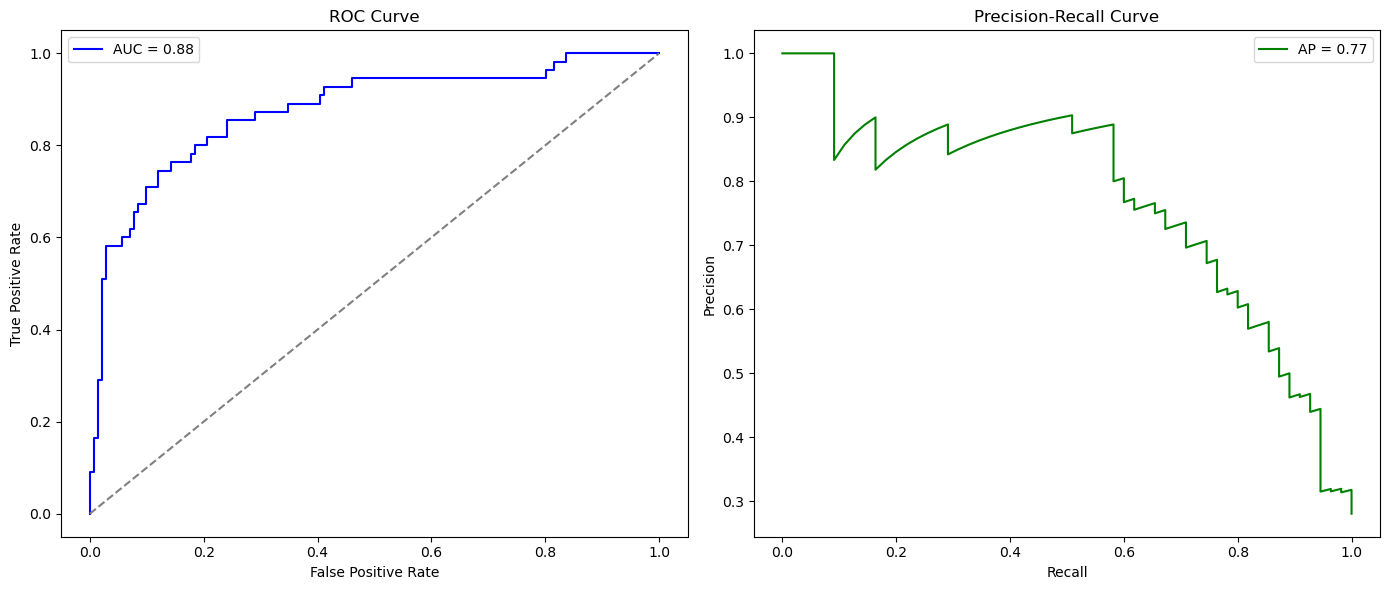


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       141
           1       0.68      0.75      0.71        55

    accuracy                           0.83       196
   macro avg       0.79      0.81      0.80       196
weighted avg       0.84      0.83      0.83       196


 Selected Features (Backward Selection):
['matched_2021', 'new_item_2022', 'total_fat', 'carbohydrates', 'sugar', 'protein', 'price', 'food_category_Beverages', 'food_category_Entrees', 'food_category_Fried Potatoes', 'food_category_Salads', 'food_category_Sandwiches']
🔝 Top Features (Permutation Importance):
total_fat                   0.122959
protein                     0.120408
matched_2021                0.094898
food_category_Sandwiches    0.092857
carbohydrates               0.087245
new_item_2022               0.085204
food_category_Beverages     0.081633
price                       0.079592
sugar                       0

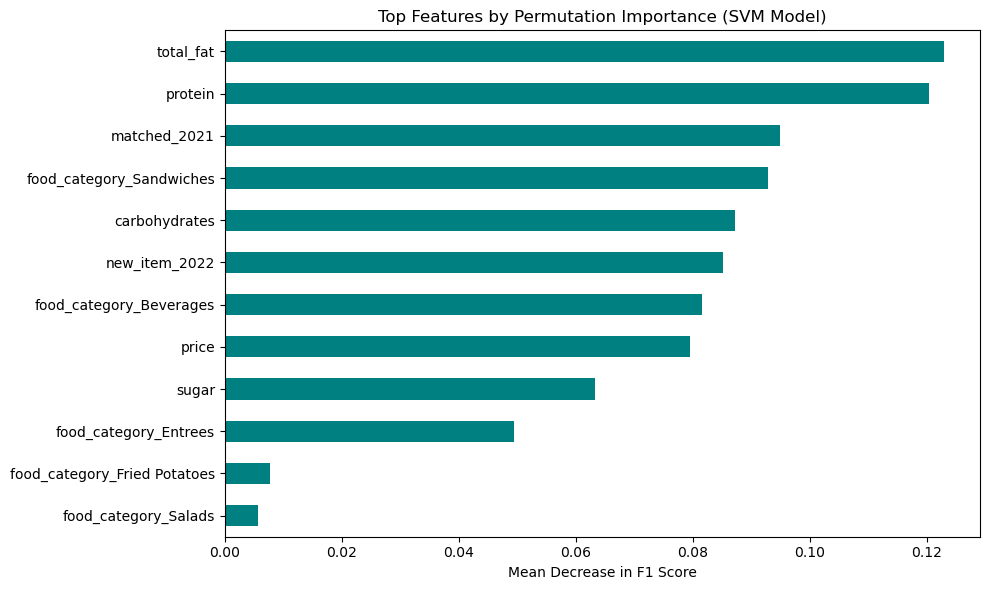

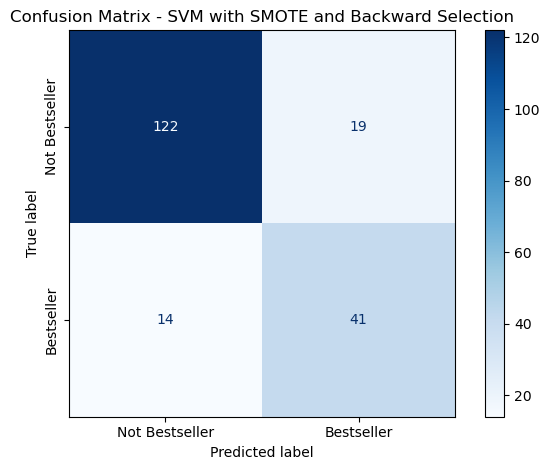

F1 Score: 0.7130


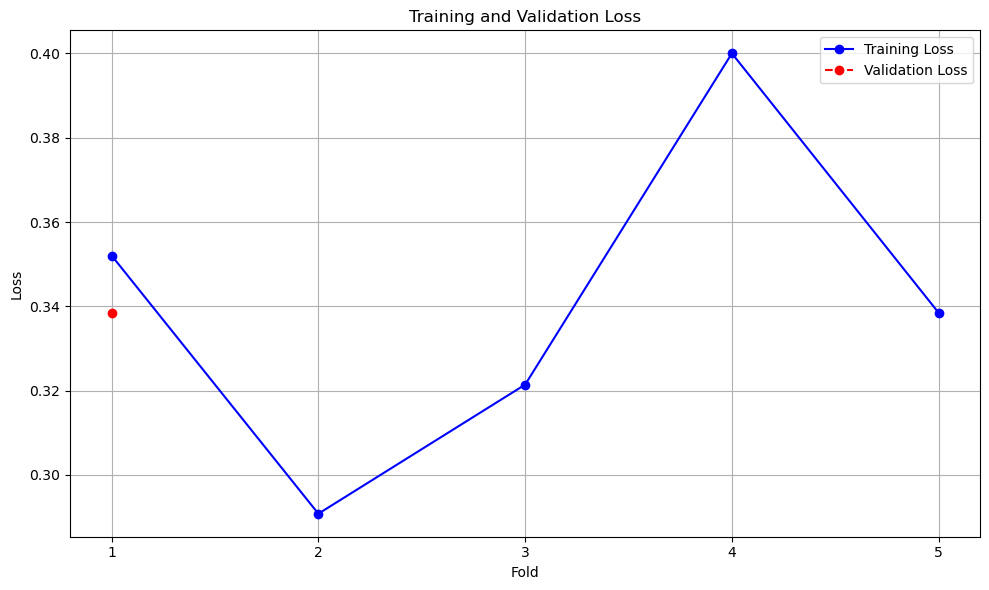

In [13]:
#### FINAL MODEL #####
### SVM with smote and backward feature selection 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    classification_report
)
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv("clean_data/final_merged_data.csv")

# Clean & convert necessary columns
df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
df['sodium'] = pd.to_numeric(df['sodium'], errors='coerce')
df['price'] = df['price'].replace('[\$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop unwanted columns
df = df.drop(columns=['item', 'ms_item', 'item_description', 'restaurant'])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['food_category'], drop_first=True)

# Fill missing values
df = df.fillna(df.median(numeric_only=True))

# Define features and target
X = df.drop(columns=['bestseller'])
y = df['bestseller'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define base SVM pipeline (SMOTE -> Scaling -> Feature Selection -> SVC)
base_svc = SVC(class_weight='balanced', probability=True)

pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=5300)),
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(
        estimator=base_svc,
        n_features_to_select='auto',
        direction='backward',
        scoring='f1',
        cv=3,
        n_jobs=-1
    )),
    ('svc', base_svc)
])

# Grid search
param_grid = {
    'svc__C': [1, 10],
    'svc__gamma': [0.1, 1],
    'svc__kernel': ['rbf']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("\nBest Parameters:")
print(grid_search.best_params_)

# Predict on test set
y_scores = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# ROC/PR Curves
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0].set_title("ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()

axs[1].plot(recall, precision, color='green', label=f'AP = {pr_auc:.2f}')
axs[1].set_title("Precision-Recall Curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

plt.tight_layout()
plt.show()

# Final report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Extract the fitted feature selector step
sfs = best_model.named_steps['sfs']

# Get selected features mask and names
selected_feature_mask = sfs.get_support()
selected_features = X.columns[selected_feature_mask]

print("\n Selected Features (Backward Selection):")
print(list(selected_features))

## permuation importance
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Run permutation importance on the test set
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create Series of importances
importances = pd.Series(result.importances_mean, index=X.columns)

# Sort and show top features
top_features = importances.sort_values(ascending=False)
print("🔝 Top Features (Permutation Importance):")
print(top_features.head(10))

# Plot the feature importances
# Filter out features with zero importance
non_zero_importance_features = top_features[top_features > 0]

# Create a Series of non-zero importance features
importances_series = pd.Series(non_zero_importance_features).sort_values()

# Plot the non-zero importance features
plt.figure(figsize=(10, 6))
importances_series.plot(kind='barh', color='teal')
plt.xlabel("Mean Decrease in F1 Score")
plt.title("Top Features by Permutation Importance (SVM Model)")
plt.tight_layout()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Bestseller", "Bestseller"])
disp.plot(cmap=plt.cm.Blues)

ax = plt.gca()
ax.set_yticklabels(["Not Bestseller", "Bestseller"], va='center', rotation=90)
ax.set_xticklabels(["Not Bestseller", "Bestseller"], ha='center')

plt.title("Confusion Matrix - SVM with SMOTE and Backward Selection")
plt.tight_layout()
plt.show()

f1_score = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_score:.4f}")

# Training and validation loss graph
training_loss = [1 - score for score in accuracy_scores]
validation_loss = [1 - acc]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, marker='o', linestyle='--', color='r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.xticks(range(1, len(training_loss) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



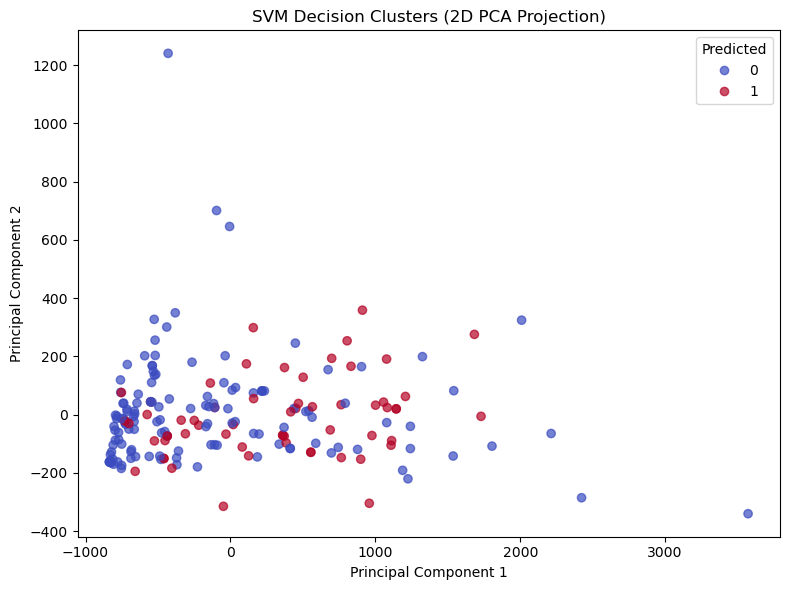

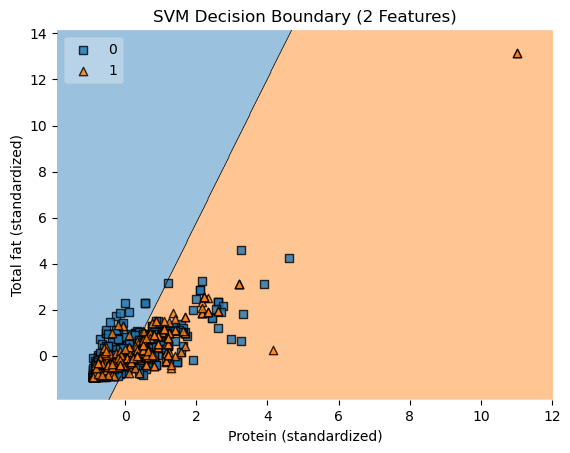

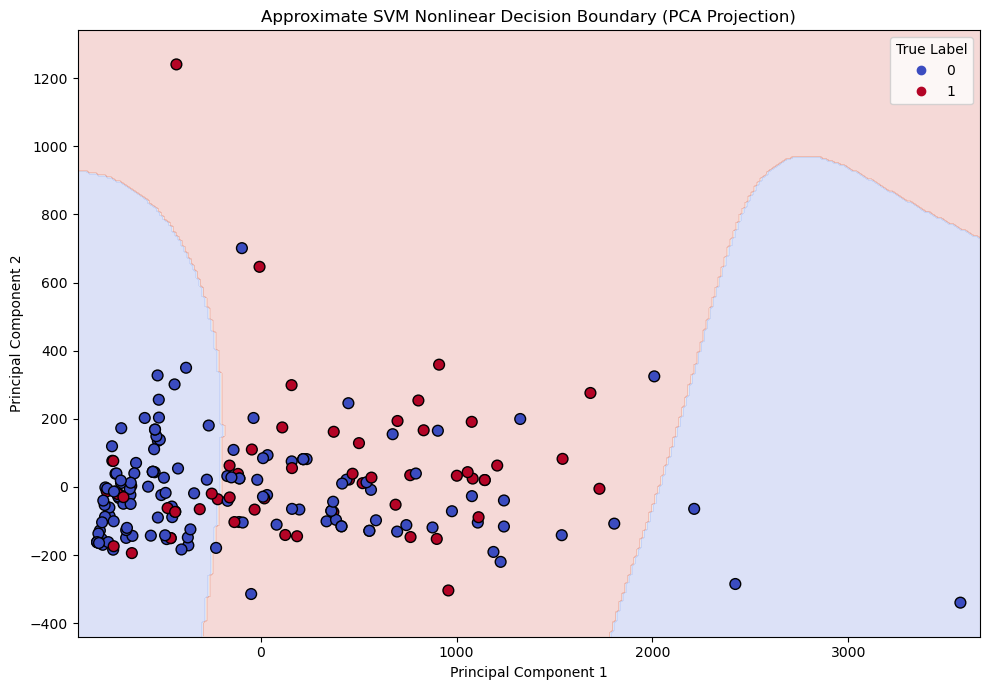

In [64]:
### Visualizing clustering and decsision boundary

## reduce dimensions with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_test)

# Predict labels
y_pred = best_model.predict(X_test)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_pred, cmap='coolwarm', alpha=0.7)
plt.title("SVM Decision Clusters (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Predicted")
plt.tight_layout()
plt.show()

## Visualize decision boundary for total_fat and protein
from mlxtend.plotting import plot_decision_regions

# Use just 2 features
X_2feat = X[['protein', 'total_fat']].values
y_2 = y.values

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_2feat)

# Train SVM directly
from sklearn.svm import SVC
svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_scaled, y_2)

# Plot decision regions
plot_decision_regions(X_scaled, y_2, clf=svm, legend=2)
plt.xlabel("Protein (standardized)")
plt.ylabel("Total fat (standardized)")
plt.title("SVM Decision Boundary (2 Features)")
plt.show()


#### Plot nonlinear deicision boundary

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

#PCA on the full test set
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

# Train a new SVM on the 2D PCA data
svm_2d = SVC(kernel='rbf', class_weight='balanced')
svm_2d.fit(X_pca, y_test)

# Create meshgrid
x_min, x_max = X_pca[:, 0].min() - 100, X_pca[:, 0].max() + 100
y_min, y_max = X_pca[:, 1].min() - 100, X_pca[:, 1].max() + 100
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict on grid and reshape
Z = svm_2d.predict(grid).reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', s=60)
plt.title("Approximate SVM Nonlinear Decision Boundary (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="True Label")
plt.tight_layout()
plt.show()



Fitting 5 folds for each of 4 candidates, totalling 20 fits


<>:23: SyntaxWarning: invalid escape sequence '\$'
<>:25: SyntaxWarning: invalid escape sequence '\$'
<>:23: SyntaxWarning: invalid escape sequence '\$'
<>:25: SyntaxWarning: invalid escape sequence '\$'
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/4229064982.py:23: SyntaxWarning: invalid escape sequence '\$'
  df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_76251/4229064982.py:25: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True)



Best Parameters:
{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf'}


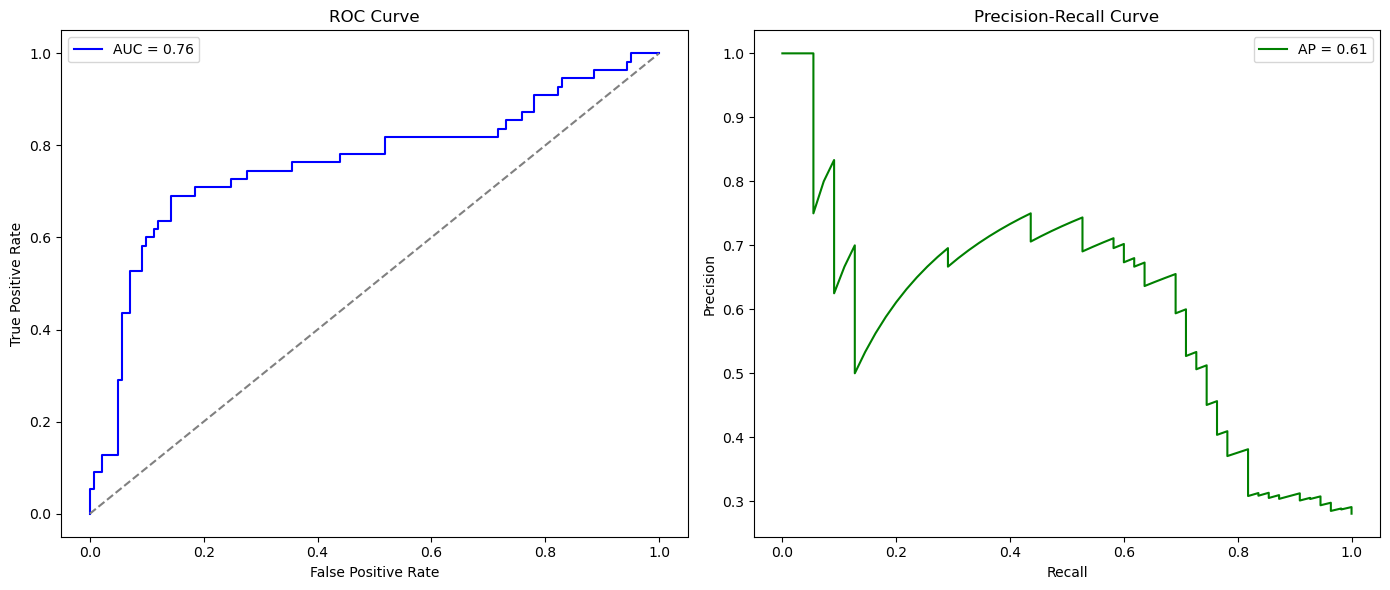


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       141
           1       0.68      0.62      0.65        55

    accuracy                           0.81       196
   macro avg       0.77      0.75      0.76       196
weighted avg       0.81      0.81      0.81       196


 Selected Features (Backward Selection):
['total_fat', 'trans_fat', 'cholesterol', 'sodium', 'dietary_fiber', 'protein', 'price', 'food_category_Burgers', 'food_category_Entrees', 'food_category_Fried Potatoes', 'food_category_Salads', 'food_category_Sandwiches']


In [57]:
### SVM (NO SMOTE) and backward feature selection 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    classification_report
)
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.pipeline import Pipeline as ImbPipeline

# Load data
df = pd.read_csv("clean_data/final_merged_data.csv")

# Clean & convert necessary columns
df['sodium'] = df['sodium'].replace('[\$,]', '', regex=True)
df['sodium'] = pd.to_numeric(df['sodium'], errors='coerce')
df['price'] = df['price'].replace('[\$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop unwanted columns
df = df.drop(columns=['item', 'ms_item', 'item_description', 'restaurant'])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['food_category'], drop_first=True)

# Fill missing values
df = df.fillna(df.median(numeric_only=True))

# Define features and target
X = df.drop(columns=['bestseller'])
y = df['bestseller'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define base SVM pipeline (Scaling -> Feature Selection -> SVC)
base_svc = SVC(class_weight='balanced', probability=True)

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(
        estimator=base_svc,
        n_features_to_select='auto',
        direction='backward',
        scoring='f1',
        cv=3,
        n_jobs=-1
    )),
    ('svc', base_svc)
])

# Grid search
param_grid = {
    'svc__C': [1, 10],
    'svc__gamma': [0.1, 1],
    'svc__kernel': ['rbf']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("\nBest Parameters:")
print(grid_search.best_params_)

# Predict on test set
y_scores = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# ROC/PR Curves
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[0].set_title("ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()

axs[1].plot(recall, precision, color='green', label=f'AP = {pr_auc:.2f}')
axs[1].set_title("Precision-Recall Curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

plt.tight_layout()
plt.show()

# Final report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Extract the fitted feature selector step
sfs = best_model.named_steps['sfs']

# Get selected features mask and names
selected_feature_mask = sfs.get_support()
selected_features = X.columns[selected_feature_mask]

print("\n Selected Features (Backward Selection):")
print(list(selected_features))
